In [ ]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from functions_ import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Illumina_functions import *
import scipy
from linker_analysis_functions  import *

### Data processing 
Demultiplexing, quality filtering

In [24]:
### define the necessary variables

base_dir = os.getcwd() 

catch_left = 'actgtctgttttcctgaattc'.upper() # region before retron seq
catch_right = 'gtacgaattcaggaaa'.upper() # region after retron seq

Barcodes = {"BC1_fwd": "AAGG", 
            "BC1_rev" : "ATCA", 
            "BC2_fwd":	"AGTC",
            "BC2_rev":	"GCCG", 
            "BC3_fwd":	"AGGA",
            "BC3_rev":	"AATT",}



Primer_seq = {"_fwd": "agcgagaggtttatcattaaggtcaac".upper(),
              "_rev":"aggcttttgacttggctgaggag".upper()}

Primer_out_of_triplets = {"_fwd": 0, 
                          "_rev": 0}


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [26]:

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
#ref_gene = amplicon_seq

used_BCs = ["BC1", "BC2", "BC3"]

variant = "RetronLib"
filter_for_n_mut = False
read_len_treshold = None

## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities, base_dir = f"{os.getcwd()}/data/fastq/P0111_RetronLib"
)

all_reads, all_ids = demultiplex_reads(a_seq, b_seq, ref_gene = None ,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = used_BCs, Sections = [""], max_mismatch_primerseq = 5, filter_for_n_mut = filter_for_n_mut, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= read_len_treshold, Primer_out_of_triplets= Primer_out_of_triplets, cut_primer_start=False, cut_BC_seq=True)


total reads 92086
[0, 2, 6, 8, 11, 12, 17, 18, 24, 25]
33237
6941 b reads are empty
3377 a reads are empty
24860 forward reads with matching BC and primer seq
18871 reads with index swapping
BC1  24860 reads before filtering
################# Done: BC1 
################# Done: BC1
[3, 5, 7, 9, 16, 19, 20, 29, 31, 34]
26794
5306 b reads are empty
2637 a reads are empty
19470 forward reads with matching BC and primer seq
15921 reads with index swapping
BC2  19470 reads before filtering
################# Done: BC2 
################# Done: BC2
[1, 13, 14, 15, 21, 22, 23, 28, 32, 36]
13558
4851 b reads are empty
1180 a reads are empty
9280 forward reads with matching BC and primer seq
12687 reads with index swapping
BC3  9280 reads before filtering
################# Done: BC3 
################# Done: BC3


In [27]:
## cut all reads to region of interest (complementary region of the retron that will in the end bind to the target region): 
for key, reads in all_reads.items():
    if "R1" in key: 
        all_reads[key] = [read[read.index(catch_left)+len(catch_left):read.index(catch_right)] if catch_left in read and catch_right in read else "" for read in reads ]
        all_reads
    elif "R2" in key:
        all_reads[key] = [read[read.index(dna_rev_comp(catch_right))+len(catch_right):read.index(dna_rev_comp(catch_left))] if dna_rev_comp(catch_right) in read  and dna_rev_comp(catch_left) in read else "" for read in reads ]


In [31]:
print(sum([a != "" for a in all_reads["BC3__R1"]]), "total reads")

6081

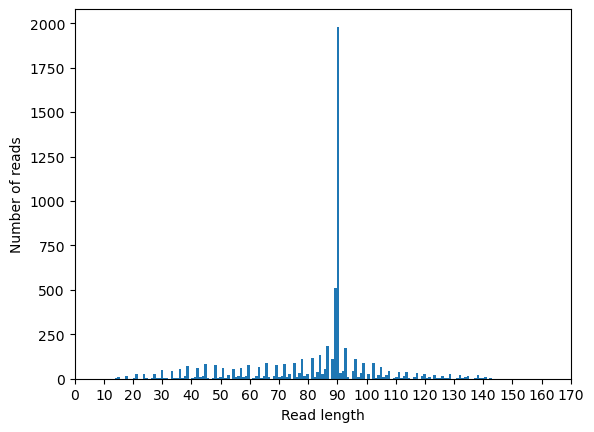

In [27]:
plt.hist([len(read) for read in all_reads["BC3__R1"]if read != ""], bins=150)
plt.ylabel("Number of reads")
plt.xticks(np.arange(0, 180,10 ))
#plt.xlim(80,100)
plt.xlabel("Read length")
plt.show()

In [ ]:
#### save the data to fasta files

# Bc = "BC1"

# Read_dir = "R2"

# reads = all_reads[f"{Bc}__{Read_dir}"] if Read_dir == "R1" else [dna_rev_comp(r) for r in all_reads[f"{Bc}__{Read_dir}"]]

# output_file = f"data/fastq/P0111_Retrons/{variant}_{Bc}_Nt_filt_{Read_dir}_001.fasta"
# sequences = [SeqIO.SeqRecord(Seq(read), id = all_ids[f"{Bc}__{Read_dir}"][i], description = f"{variant} {Bc} DNA sequence") for i, read in enumerate(reads)]

# count = SeqIO.write(sequences, output_file, "fasta")
# with open(output_file, "w") as output_handle:
#     SeqIO.write(sequences, output_handle, "fasta")
# print("Saved %i records to %s" % (count, output_file))

In [ ]:
## how much index swapping is there?
same_bc = 0
diff_bc = 0

BC_corresp = { "AAGG" : "ATCA", 
            "AGTC" : "GCCG", 
            "AGGA" :	"AATT"}

for idx, a_read in enumerate(a_seq): 
    Bc1 = a_read[:4]
    if Bc1 not in BC_corresp.keys():
        diff_bc += 1
        continue
    if BC_corresp[Bc1] == b_seq[idx][:4]:
        same_bc += 1  
    else: 
        diff_bc += 1
        
print("same BC: ", same_bc)
print("idx swapping BC: ", diff_bc)
print(diff_bc/(same_bc+diff_bc), " of reads have swapped BCs") # roughly 40% !!!!!

### Data analysis 
Please, before running the steps below, run **blastn** to align the demultiplexed and cleaned reads (from above), to the reference (e.g. AraC-LOV2) sequence. 

In [8]:
### define variables for the analysis
homedir = "data/Illumina/P0111_RetronLib"#P01_DP6_LOV2/" #P02_RL8_LOV2


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
    }

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
    }



ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

with open(f"{homedir}/config.json") as f:
    config = json.load(f)


In [15]:
import json

Bc = "BC3"
read_dir = "R1" ## we only use the forward read, since the reverse read is of worse quality
variant = "RetronLib"
section = "S1"
blast_alignments = []

# Open the JSON file and load it as a dictionary
with open(f"{os.getcwd()}/data/Illumina/P0111_RetronLib/blast/alignments/{variant}_{Bc}_{section}_Nt_filt_{read_dir}.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>


blast_alignments_read_dir = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()


ref_alignment_region = config["amplicon"]
#"CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC" ## region used for alignment of reads 

LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "cggccaaa".upper()


LOV2_start_idx = ref_alignment_region.index(LOV_startseq)
LOV2_end_idx = ref_alignment_region.index(LOV_endseq) + len(LOV_endseq)

FigFolder = f"{os.getcwd()}/final_output/P0111_RetronLib/{Bc}_{read_dir}/blastpipeline/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)  

blast_alignments = blast_alignments + blast_alignments_read_dir



<class 'dict'>


In [10]:
blast_alignments

[{'num': 1,
  'description': [{'id': 'gnl|BL_ORD_ID|1492',
    'accession': '1492',
    'title': 'M02524:163:000000000-LPH6G:1:2110:23424:5900 RetronLib BC3 DNA sequence'}],
  'len': 138,
  'hsps': [{'num': 1,
    'bit_score': 250.418,
    'score': 135,
    'evalue': 7.92625e-68,
    'identity': 137,
    'query_from': 57,
    'query_to': 194,
    'query_strand': 'Plus',
    'hit_from': 1,
    'hit_to': 138,
    'hit_strand': 'Plus',
    'align_len': 138,
    'gaps': 0,
    'qseq': 'GCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCT',
    'hseq': 'GCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCGTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCT',
    'midline': '|||||||||||||||||||||||||||||||||||||||||||| |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||'}]},
 {'num': 2,
  'description': [{'id': 'gnl|BL_ORD_ID|939',


In [16]:
RL_encoded_mutations = [0]*len(ref_alignment_region) # list to store the number of changes at each position
RL_encoded_insertions = [0]*len(ref_alignment_region) # list to store the number of indels at each position
RL_encoded_deletions = [0]*len(ref_alignment_region) # list to store the number of indels at each position
coverage = [0]*len(ref_alignment_region) # list to store the number of reads covering each position

print("total reads:", len(blast_alignments))
for alignment in blast_alignments:
    qseq = alignment["hsps"][0]["qseq"].upper()
    hseq = alignment["hsps"][0]["hseq"].upper()
    seq_id = alignment["description"][0]["title"]
    midline = alignment["hsps"][0]["midline"]

    query_from  = alignment["hsps"][0]["query_from"] -1 # -1 to correct for 0-based indexing in python
    query_to = alignment["hsps"][0]["query_to"]

    for pos in range(query_from, query_to):
        coverage[pos] += 1
    # if query_to - query_from < 85 or query_to - query_from > 95: 
    #     continue
    
    if "-" in qseq or "-" in hseq:
        # Track how much insertions have shifted the sequence
        shift = 0  

        for i, nt in enumerate(qseq):
            pos = query_from + i - shift  # Adjust position for past insertions
            if hseq[i] == "-":

                RL_encoded_deletions[pos] += 1 ## here, no shift + 1 needed since deletions in the **read** do not infere with the indexing when mappping to the **reference** (no shift of the ref position)
            if nt == "-":
                RL_encoded_insertions[pos] += 1  # Mark insertion at the previous reference position
                shift += 1  # Increase shift due to insertion  
    
    else: 
        hotencoding = [0 if midline[i] == "|" else 1 for i in range(len(midline))]
        for pos, val in enumerate(hotencoding):
            RL_encoded_mutations[query_from + pos] += val
        
    

total reads: 5794


In [ ]:
# RL_encoded_mutations = np.array(RL_encoded_mutations)
# RL_encoded_insertions = np.array(RL_encoded_insertions)
# RL_encoded_deletions = np.array(RL_encoded_deletions)
# coverage = np.array(coverage)
# ###### lets not correct for coverage, since we are ideed interested in the number of mappings per position (howerver, thereby we might include some positional biases of the illumina sequencing)
# # RL_encoded_mutations =RL_encoded_mutations/coverage
# # RL_encoded_insertions = RL_encoded_insertions/coverage
# # RL_encoded_deletions = RL_encoded_deletions/coverage

In [17]:
coverage_R1 = coverage.copy()

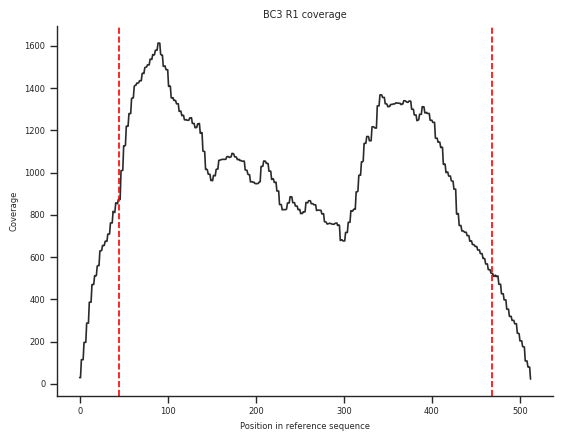

In [19]:
plt.plot(coverage)
plt.ylabel("Coverage")
plt.xlabel("Position in reference sequence")
plt.title(f"{Bc} {read_dir} coverage")

plt.axvline(LOV2_start_idx, color="red", linestyle="--", label="LOV2")
plt.axvline(LOV2_end_idx, color="red", linestyle="--",)

plt.savefig(f"{FigFolder}/{Bc}_RL_coverage.pdf")
plt.savefig(f"{FigFolder}/{Bc}_RL_coverage.png")

plt.show()

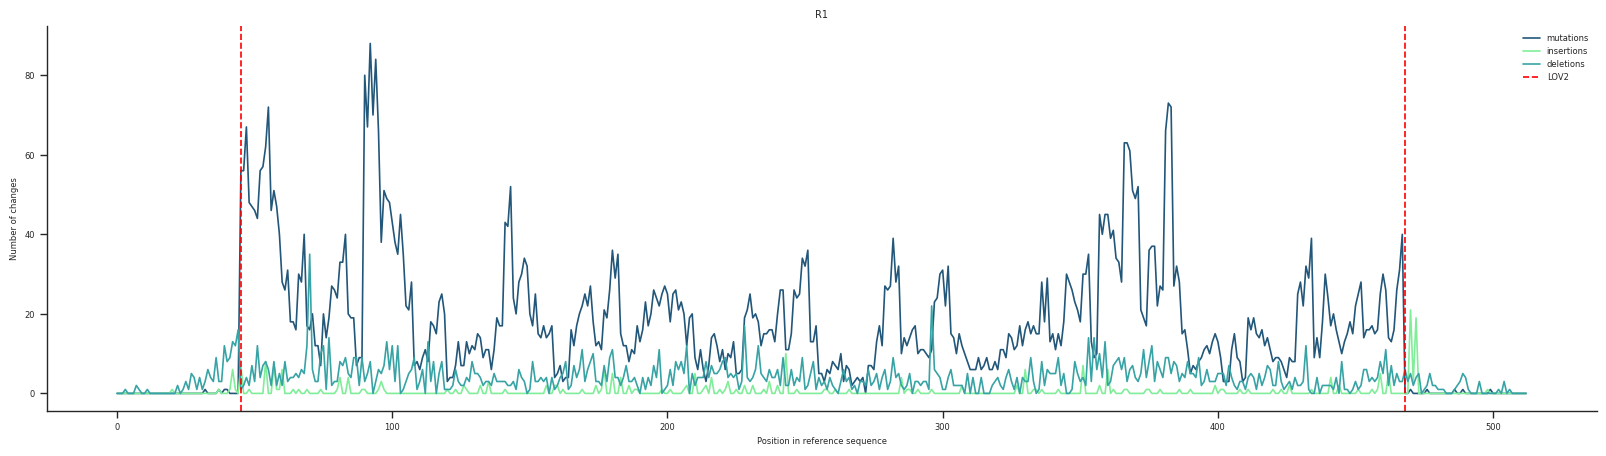

In [24]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(RL_encoded_mutations, label="mutations", color = "#22577A")
plt.plot(RL_encoded_insertions, label = "insertions", color = "#80ED99")
plt.plot(RL_encoded_deletions, label = "deletions", color = "#38A3A5")
plt.axvline(LOV2_start_idx, color="red", linestyle="--", label="LOV2")
plt.axvline(LOV2_end_idx, color="red", linestyle="--",)
plt.legend(frameon=False)
plt.xlabel("Position in reference sequence")
plt.ylabel("Number of changes")
plt.title(read_dir)
plt.savefig(f"{FigFolder}/{Bc}_RL_encoded_changes.pdf")
plt.savefig(f"{FigFolder}/{Bc}_RL_encoded_changes.png")
plt.show()


In [26]:
if not os.path.exists(f"{FigFolder}/enrichments/"):
    os.makedirs(f"{FigFolder}/enrichments/")
pd.DataFrame(RL_encoded_deletions).to_csv(f"{FigFolder}/enrichments/{Bc}_RL_encoded_deletions.csv")
pd.DataFrame(RL_encoded_insertions).to_csv(f"{FigFolder}/enrichments/{Bc}_RL_encoded_insertions.csv")
pd.DataFrame(RL_encoded_mutations).to_csv(f"{FigFolder}/enrichments/{Bc}_RL_encoded_mutations.csv")

In [55]:
compared_to = "RL8_BC1"
observed_muts = pd.read_csv(f"{os.getcwd()}/final_output/RL8/combined/enrichments/DNA/{compared_to}_S1_combined_roiTrue_DNA_enrichment_relative.csv", index_col=0)
indels_counts = pd.read_csv(f"{os.getcwd()}/final_output/RL8/combined/enrichments/DNA/{compared_to}_S1_combined_roiTrue_DNA_indel_counts.csv", index_col=0)

In [ ]:


## set everything with mut rate = 0 to 0
total_mut_rate =list(observed_muts.sum())
changes_roi = RL_encoded_mutations[LOV2_start_idx:LOV2_start_idx+len(total_mut_rate)]

changes_roi = [RL_mut_rate if total_mut_rate[idx] != 0 else 0 for idx, RL_mut_rate in enumerate(changes_roi)]

total_mut_rate_prop = [x/sum(total_mut_rate)*100 for x in total_mut_rate]
changes_roi_prop = [x/sum(changes_roi)*100 for x in changes_roi]

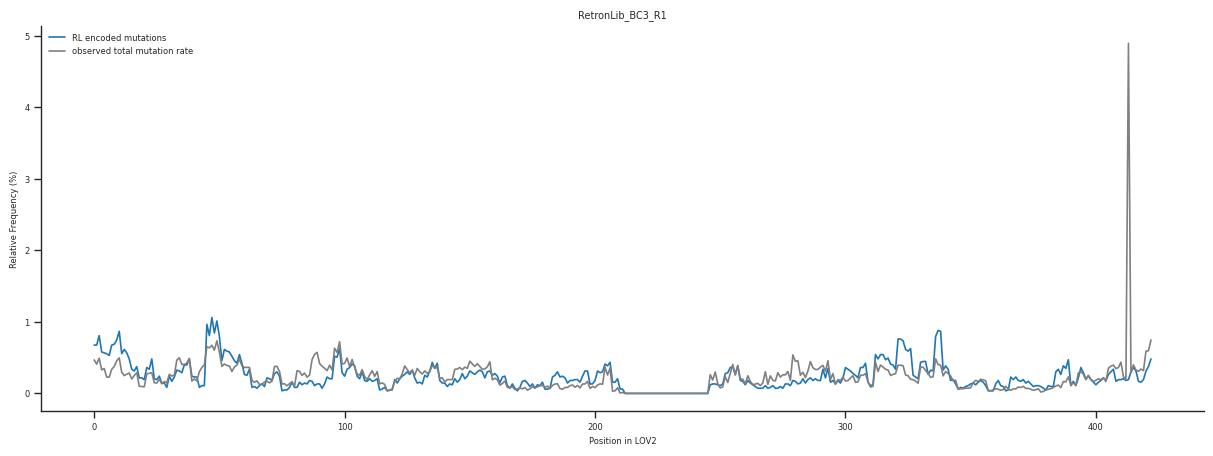

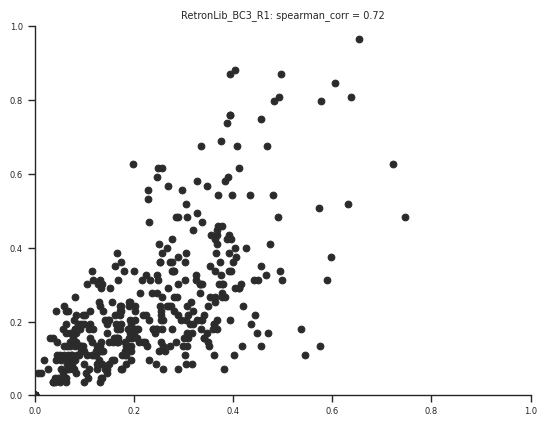

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.xlabel("Position in LOV2")
plt.ylabel("Relative Frequency (%)")
plt.plot(changes_roi_prop, label="RL encoded mutations", c = "tab:blue")
plt.plot(total_mut_rate_prop, label = "observed total mutation rate", c = "grey")
plt.legend(frameon=False)
plt.title(f"{variant}_{Bc}_{read_dir}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_mutations.pdf")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_mutations.png")
plt.show()
plt.clf()

plt.scatter(total_mut_rate_prop, changes_roi_prop)
plt.ylim(0,1)
plt.xlim(0,1)
plt.title(f"{variant}_{Bc}_{read_dir}: spearman_corr = {round(scipy.stats.spearmanr(total_mut_rate_prop, changes_roi_prop)[0],2)}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_mutations_corr.pdf")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_mutations_corr.png")
plt.show()


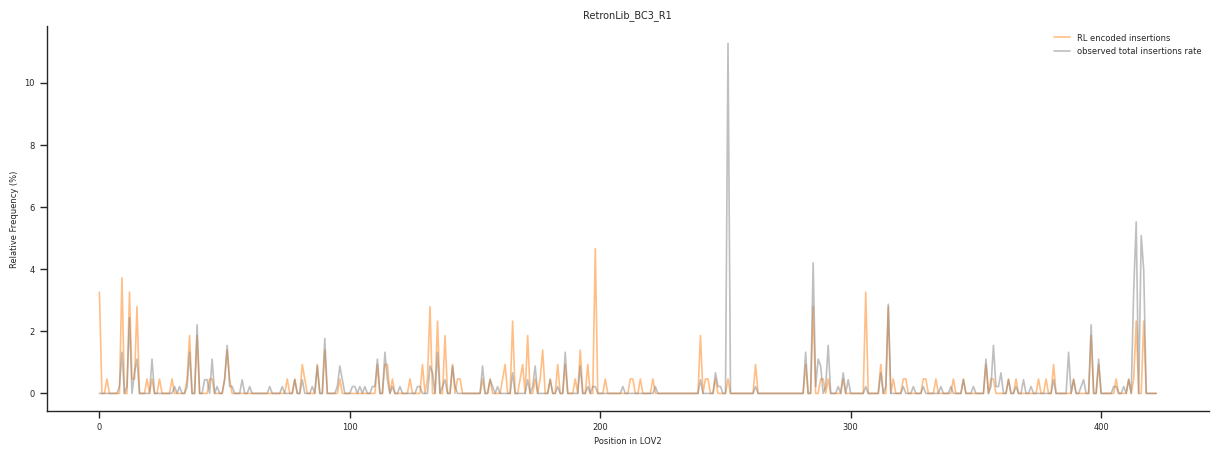

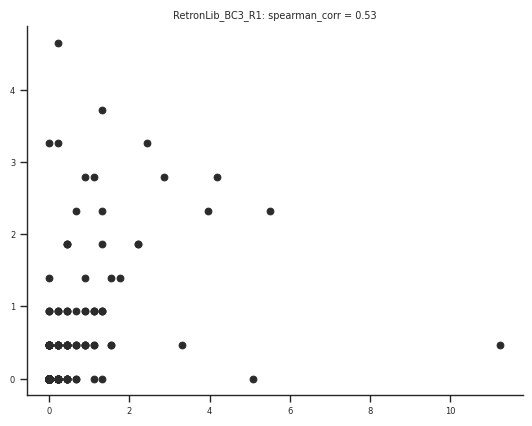

In [56]:
insertions_freq_prop = list(indels_counts.loc["insertion"]/np.sum(indels_counts.loc["insertion"])*100)
RL_insertion_roi = RL_encoded_insertions[LOV2_start_idx:LOV2_start_idx+len(insertions_freq_prop)]
RL_insertion_roi = RL_insertion_roi/np.sum(RL_insertion_roi)*100

fig, ax = plt.subplots(figsize=(15, 5))
plt.xlabel("Position in LOV2")
plt.ylabel("Relative Frequency (%)")
plt.plot(RL_insertion_roi, label="RL encoded insertions", alpha=0.5, c = "tab:orange")
plt.plot(insertions_freq_prop, label = "observed total insertions rate", alpha = 0.5, c = "grey")
# if read_dir == "R2":
#     plt.xticks(np.arange(0, len(insertions_freq_prop), 50), np.arange(len(LOV2_gene)- len(insertions_freq_prop),len(LOV2_gene), 50))
# else: 
#     plt.xticks(np.arange(0, 250, 50), np.arange(0,250, 50))
plt.legend(frameon=False)
plt.title(f"{variant}_{Bc}_{read_dir}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_{compared_to}_observed_insertions.pdf")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_{compared_to}_observed_insertions.png")
plt.show()
plt.clf()

plt.scatter(insertions_freq_prop, RL_insertion_roi)
plt.title(f"{variant}_{Bc}_{read_dir}: spearman_corr = {round(scipy.stats.spearmanr(insertions_freq_prop, RL_insertion_roi)[0],2)}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_{compared_to}_observed_insertions_corr.pdf")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_{compared_to}_observed_insertions_corr.png")
plt.show()

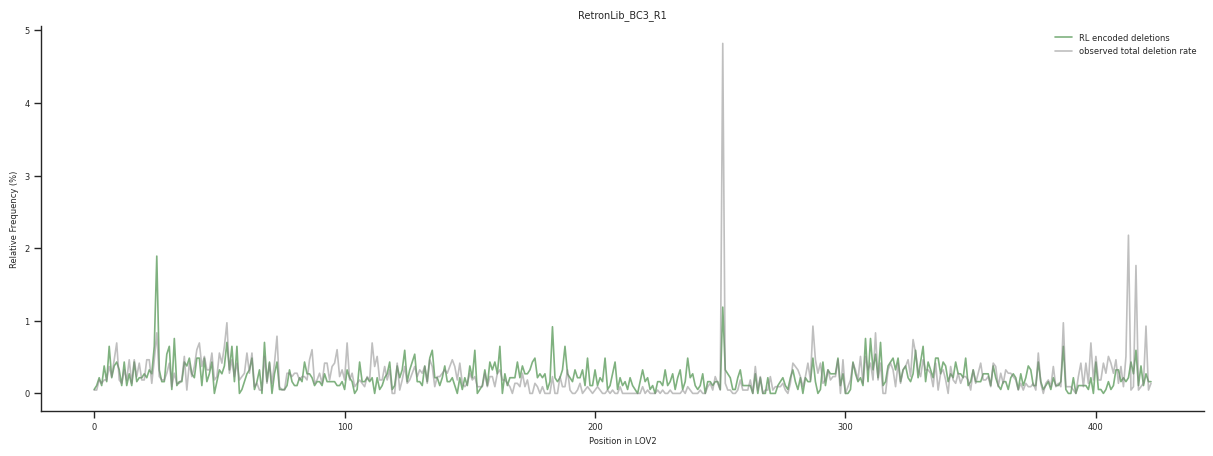

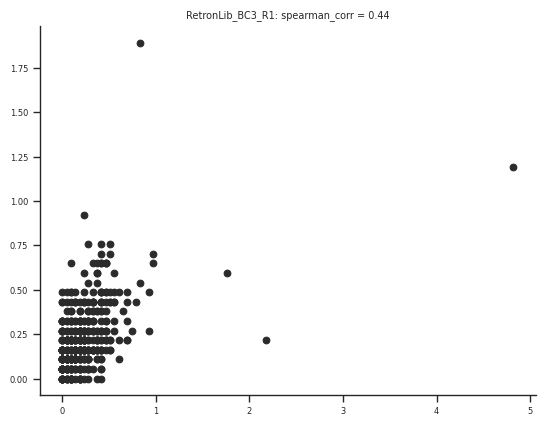

In [57]:
deletions_freq_prop = list(indels_counts.loc["deletion"]/np.sum(indels_counts.loc["deletion"])*100)
RL_del_roi = RL_encoded_deletions[LOV2_start_idx:LOV2_start_idx+len(deletions_freq_prop)] 
RL_del_roi = RL_del_roi/np.sum(RL_del_roi)*100

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(RL_del_roi, label="RL encoded deletions", alpha=0.5, c = "darkgreen")
plt.plot(deletions_freq_prop, label = "observed total deletion rate", alpha = 0.5, c = "grey")
plt.xlabel("Position in LOV2")
plt.ylabel("Relative Frequency (%)")
plt.legend(frameon=False)
plt.title(f"{variant}_{Bc}_{read_dir}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_deletions.pdf")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_deletions.png")
plt.show()
plt.clf()

plt.scatter(deletions_freq_prop, RL_del_roi)
plt.title(f"{variant}_{Bc}_{read_dir}: spearman_corr = {round(scipy.stats.spearmanr(deletions_freq_prop, RL_del_roi)[0],2)}")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_deletions_corr.pdf")
plt.savefig(f"{FigFolder}/{Bc}_{read_dir}_RL_encoded_vs_observed_{compared_to}_deletions_corr.png")
plt.show()

### Characterization of Retron library RL1 = linker library

In [186]:
import json

Bc = "BC1" # corresponds to reads of retron library 1 (linker library)
read_dir = "R1" ## we again only use the forward read, since the reverse read is of worse quality
variant = "RetronLib"
section = "S1"
linker_site = "right" ## either "left" or "right", depending on the linker site that should be analyzed

# Open the JSON file and load it as a dictionary
with open(f"{os.getcwd()}/data/Illumina/P0111_RetronLib/blast/alignments/{variant}_{Bc}_{section}_Nt_filt_{read_dir}.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>


all_blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
with open(f"{os.getcwd()}/data/Illumina/P0111_RetronLib/config.json") as f:
    config = json.load(f)

ref_alignment_region = config["amplicon"]
#"CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC" ## region used for alignment of reads 

wt_left_linker = "INESSGL"
wt_right_linker = "IDEAAKGSLHPP"

LOV_startseq = "gccacaa".upper() ## LOV2 start # set region of interest, that has to be included in the reads to be considered for the analysis, e.g. LOV2 start site
LOV_endseq = "tgctgaaaac".upper() ## LOV2 end

LOV2_start_idx = ref_alignment_region.index(LOV_startseq)
LOV2_end_idx = ref_alignment_region.index(LOV_endseq) + len(LOV_endseq)

FigFolder = f"{os.getcwd()}/final_output/P0111_RetronLib/{Bc}_{read_dir}/blastpipeline/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)  



<class 'dict'>


In [ ]:
RL_encoded_mutations = [0]*len(ref_alignment_region) # list to store the number of changes at each position
RL_encoded_insertions = [0]*len(ref_alignment_region) # list to store the number of indels at each position
RL_encoded_deletions = [0]*len(ref_alignment_region) # list to store the number of indels at each position
RL_lengths = []

print("total reads:", len(all_blast_alignments))
for alignment in all_blast_alignments:
    qseq = alignment["hsps"][0]["qseq"].upper()
    hseq = alignment["hsps"][0]["hseq"].upper()
    seq_id = alignment["description"][0]["title"]
    midline = alignment["hsps"][0]["midline"]
    RL_lengths.append(len(hseq))

    query_from  = alignment["hsps"][0]["query_from"] -1 # -1 to correct for 0-based indexing in python
    query_to = alignment["hsps"][0]["query_to"]
    
    if "-" in qseq or "-" in hseq:
        # Track how much insertions have shifted the sequence
        shift = 0  

        for i, nt in enumerate(qseq):
            pos = query_from + i - shift  # Adjust position for past insertions
            if hseq[i] == "-":

                RL_encoded_deletions[pos] += 1 ## here, no shift + 1 needed since deletions in the **read** do not infere with the indexing when mappping to the **reference** (no shift of the ref position)
            if nt == "-":
                RL_encoded_insertions[pos] += 1  # Mark insertion at the previous reference position
                shift += 1  # Increase shift due to insertion  
    
    else: 
        hotencoding = [0 if midline[i] == "|" else 1 for i in range(len(midline))]
        for pos, val in enumerate(hotencoding):
            RL_encoded_mutations[query_from + pos] += val
    

total reads: 14927


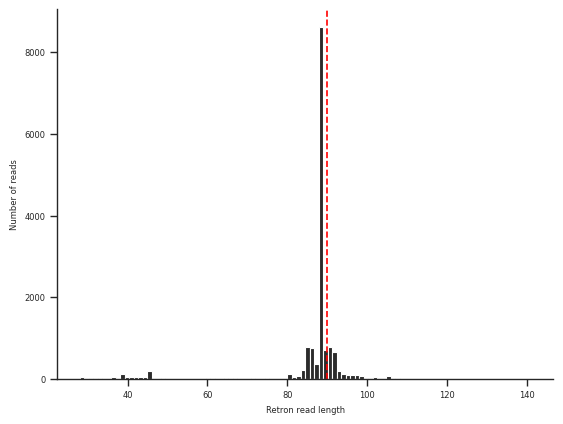

In [188]:
plt.hist(RL_lengths, bins = 100)
plt.xlabel("Retron read length")
plt.ylabel("Number of reads")
plt.axvline(90, color="red", linestyle="--")
plt.savefig(f"{FigFolder}/Retron_read_lengths.pdf")
plt.savefig(f"{FigFolder}/Retron_read_lengths.png")
plt.show()

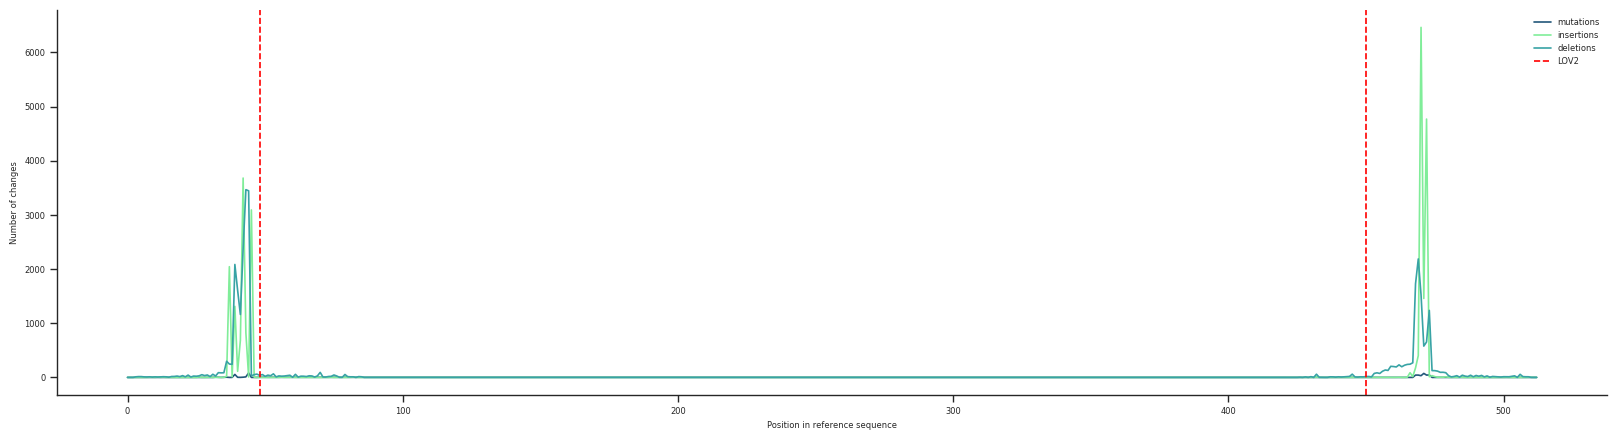

In [189]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(RL_encoded_mutations, label="mutations", color = "#22577A")
plt.plot(RL_encoded_insertions, label = "insertions", color = "#80ED99")
plt.plot(RL_encoded_deletions, label = "deletions", color = "#38A3A5")
plt.axvline(LOV2_start_idx, color="red", linestyle="--", label="LOV2")
plt.axvline(LOV2_end_idx, color="red", linestyle="--",)
plt.legend(frameon=False)
plt.xlabel("Position in reference sequence")
plt.ylabel("Number of changes")
plt.savefig(f"{FigFolder}/{Bc}_RL_encoded_changes.pdf")
plt.savefig(f"{FigFolder}/{Bc}_RL_encoded_changes.png")

plt.show()


In [ ]:
## we analyze the linker library composition as we analyzed all other linker experiments 

### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
print(len(all_blast_alignments), "alignments before filtering for LOV2 insertion site")

#strand = blast_alignments[0]["hsps"][0]["hit_strand"] # "Minus" or "Plus"

filter_for_region = LOV2_start_idx if linker_site=="left" else LOV2_end_idx 

blast_alignments = [alignment for alignment in all_blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region-10]
print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


14927 alignments before filtering for LOV2 insertion site
6389 alignments after filtering for LOV2 insertion site


In [191]:
cut_site_seq = LOV_startseq if linker_site =="left" else LOV_endseq

linker_alignments, LOV2_alignments, coverage = divide_alignments(blast_alignments, query_seq = ref_alignment_region, cut_site_seq=cut_site_seq, read_dir="R1" if linker_site=="left" else "R2")

1 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)


In [202]:
linkers, linker_list = get_linker_variants(linker_alignments,wt_linker = wt_left_linker if linker_site=="left" else wt_right_linker,read_dir="R1" if linker_site =="left" else "R2")

813 reads excluded due to frameshifts


In [208]:
## sort linkers by frequency

linkers_sorted = {k: v for k, v in sorted(linkers.items(), key=lambda item: item[1], reverse=True)}
total_reads = sum(linkers_sorted.values())
linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

# exclude wt: 
linkers_sorted_perc.pop("wt")
linkers_perc_filt = {k: v for k, v in linkers_sorted_perc.items() if v > 0.1}

linkers_perc_filt, linker_renaming = rename_left_linkers(linkers_perc_filt.keys(), linkers_perc_filt) if linker_site=="left" else rename_right_linkers(linkers_perc_filt.keys(), linkers_perc_filt)


IDEAAKPLHPP -> P
IDEAAKGQGLHPP -> GQG
IDEAAKGHGLHPP -> GHG
IDEAAKVLHPP -> V
IDEAAKWLHPP -> W
IDEAAKGCGLHPP -> GCG
IDEAAKGSGLHPP -> GSG
IDEAAKGLGLHPP -> GLG
IDEAAKGPGLHPP -> GPG
IDEAAKGMGLHPP -> GMG
IDEAAKLLHPP -> L
IDEAAKALHPP -> A
IDEAAKGEGLHPP -> GEG
IDEAAKGTGLHPP -> GTG
IDEAAKGIGLHPP -> GIG
IDEAAKQLHPP -> Q
IDEAAKGDGLHPP -> GDG
IDEAAKTLHPP -> T
IDEAAKGRGLHPP -> GRG
IDEAAKGYGLHPP -> GYG
IDEAAKGPPPPGLHPP -> GPPPPG
IDEAAKGFGLHPP -> GFG
IDEAAKGVGLHPP -> GVG
IDEAAKGWGLHPP -> GWG
IDEAAKRLHPP -> R
IDEAAKGGGLHPP -> GGG
IDEAAKGNGLHPP -> GNG
IDEAAKHLHPP -> H
IDEAAKILHPP -> I
IDEAAKGKGLHPP -> GKG
IDEAAKCLHPP -> C
IDEAAKYLHPP -> Y
IDEAAKKLHPP -> K
IDEAAKGLHPP -> G
IDEAAKFLHPP -> F
IDEAAKGAGLHPP -> GAG
IDEAAKMLHPP -> M
IDEAAKNLHPP -> N
IDEAAKSLHPP -> S
IDEAAKDLHPP -> D
IDEAAKGSGSGLHPP -> GSGSG
IDEAAKELHPP -> E
IDEGSLHPP -> (-3del)GS
IDEAAKGGSGLHPP -> GGSG
IDEAAKPP -> (+2del)
IDEAAKGSGGLHPP -> GSGG
IDEAAKGPPGLHPP -> GPPG
IDEAAKGPPPGLHPP -> GPPPG
IGSLHPP -> (-5del)GS
IDEAAKPPLHPP -> PP
IDGSLHPP ->

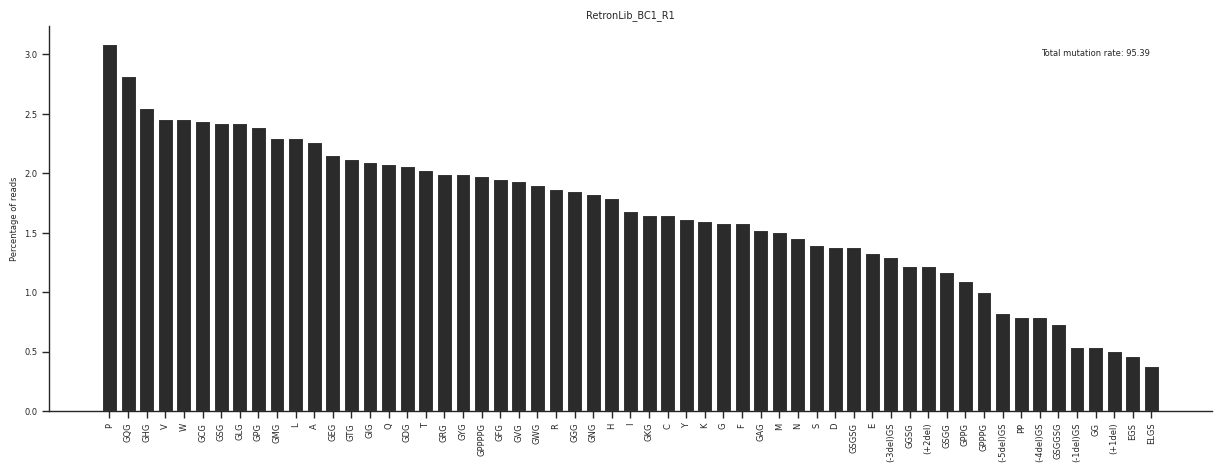

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.title(f"{variant}_{Bc}_{read_dir}")
plt.savefig(f"{FigFolder}/{variant}_{Bc}_{linker_site}_linker_distribution.pdf", bbox_inches="tight")
plt.savefig(f"{FigFolder}/{variant}_{Bc}_{linker_site}_linker_distribution.png", bbox_inches="tight")
plt.show()

In [210]:
site = "R1" if linker_site=="left" else "R2"
compared_to = "R35_BC2"
linker_distr = pd.read_csv(f"{os.getcwd()}/output/R35/blast00/{site}/enrichments/AA/{compared_to}_S1_{site}_AA_linker_distribution.csv", index_col=0).T
linker_distr.index = ["observed"]

In [211]:
for linker, freq in linkers_perc_filt.items():
    linker_distr.loc["encoded", linker] = freq

## fill nas with 0
linker_distr = linker_distr.fillna(0)

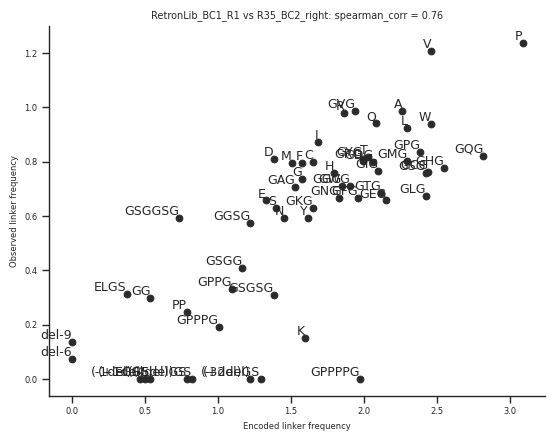

In [212]:
plt.scatter(linker_distr.loc["encoded",:], linker_distr.loc["observed",:])
corr = round(scipy.stats.spearmanr(linker_distr.loc["encoded",:], linker_distr.loc["observed",:])[0],2)
for col in linker_distr.columns:
    plt.text(
        linker_distr.loc["encoded", col],  # X-coordinate
        linker_distr.loc["observed", col],  # Y-coordinate
        col,  # Annotation (column name)
        fontsize=9,
        ha='right',  # Align text to the right
        va='bottom',  # Align text to the bottom
    )
    
plt.xlabel("Encoded linker frequency")
plt.ylabel("Observed linker frequency")
plt.title(f"{variant}_{Bc}_{read_dir} vs {compared_to}_{linker_site}: spearman_corr = {corr}")
plt.savefig(f"{FigFolder}/{variant}_{Bc}_encoded_vs_observed_in_{compared_to}_{linker_site}_linker.pdf")
plt.savefig(f"{FigFolder}/{variant}_{Bc}_encoded_vs_observed_in_{compared_to}_{linker_site}_linker.png")
plt.show()